## Model Perfromance Metrics
### Christopher V. Cosgriff, MPH
#### NYU School of Medicine
<hr />

## 0 - Environement

In [1]:
import pandas as pd
import pickle

from sequential_model import SequentialModel
from modelanalysis import APACHEWrapper
from modelanalysis import gen_auc_plot, gen_calib_plot, gen_prc_plot
from modelanalysis import nri_grid, opr_table

# Load seaborn to set plot styles
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1 - Models and Data


In [2]:
test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid').values
test_y = pd.read_csv('../extraction/data/test_y.csv').values.ravel()

test_apache = pd.read_csv('../extraction/data/test_apache.csv').values.ravel()
apache_model = APACHEWrapper(test_apache)

logit_full = pickle.load(open('./logit_full', 'rb'))

logit_HR = pickle.load(open('./logit_HR', 'rb'))
logit_hHR = pickle.load(open('./logit_hHR', 'rb'))
seq_logit_HR = SequentialModel(logit_full, logit_HR, cutoff=0.10)
seq_logit_hHR = SequentialModel(logit_full, logit_hHR, cutoff=0.50)

xgb_full = pickle.load(open('./xgb_full', 'rb'))

## 2 - Reciever Operator Characteristic and Precision-Recall Curves

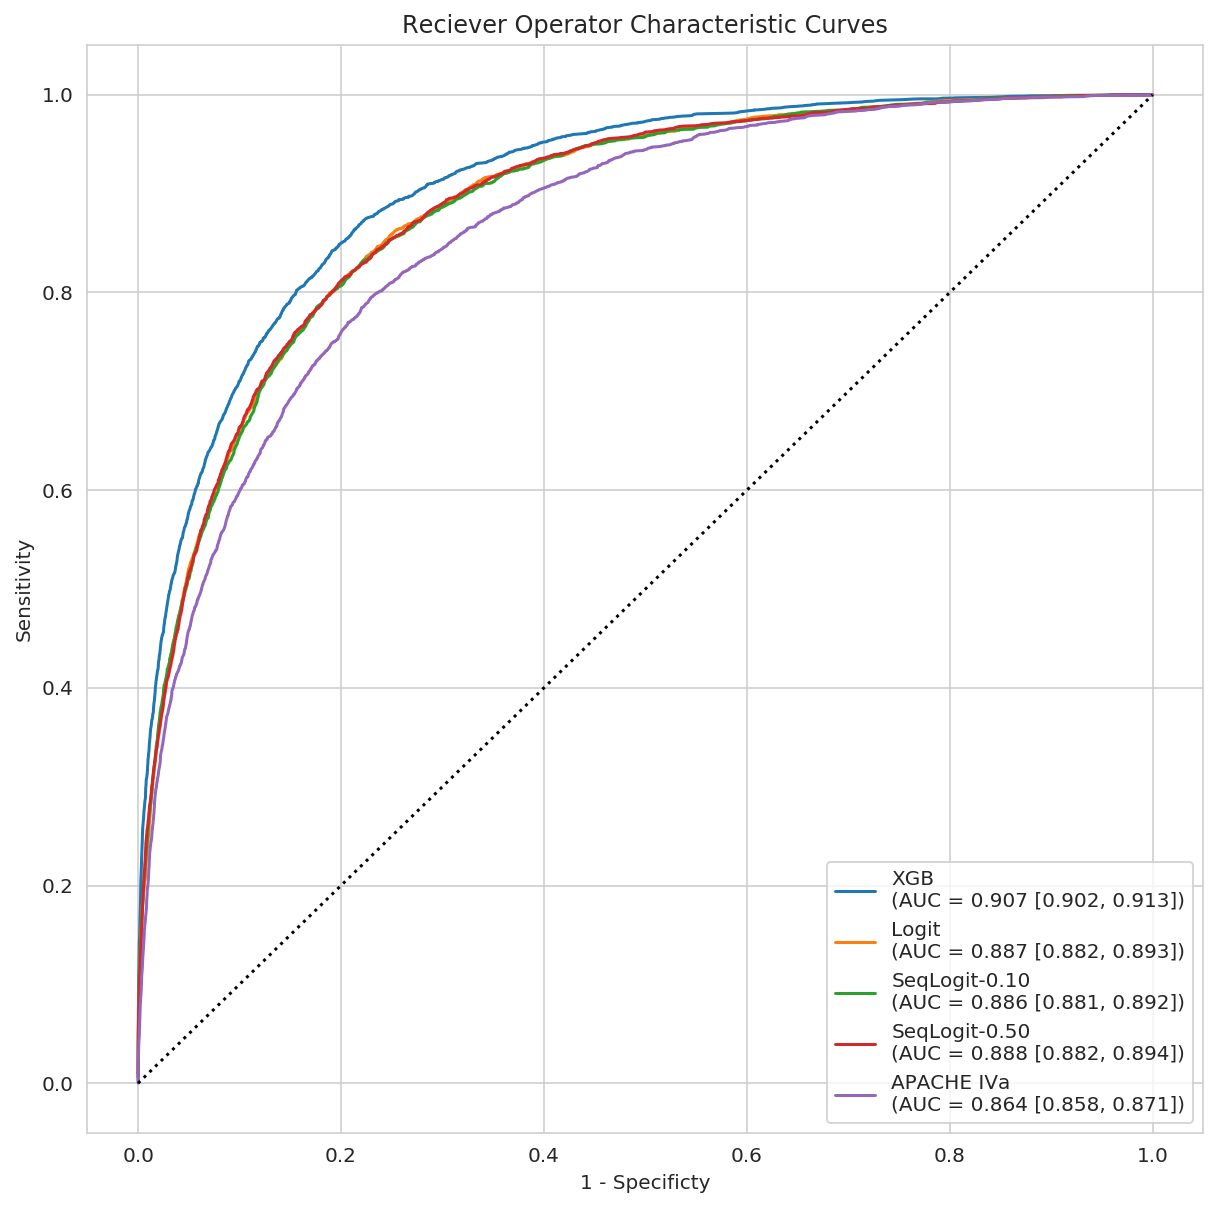

In [3]:
gen_auc_plot(models=[xgb_full, logit_full, seq_logit_HR, seq_logit_hHR, apache_model],
             names=['XGB', 'Logit', 'SeqLogit-0.10','SeqLogit-0.50', 'APACHE IVa'], 
             title='Reciever Operator Characteristic Curves', X=test_X, y=test_y, ci_level=0.95,
             save_name='auroc_all_models')

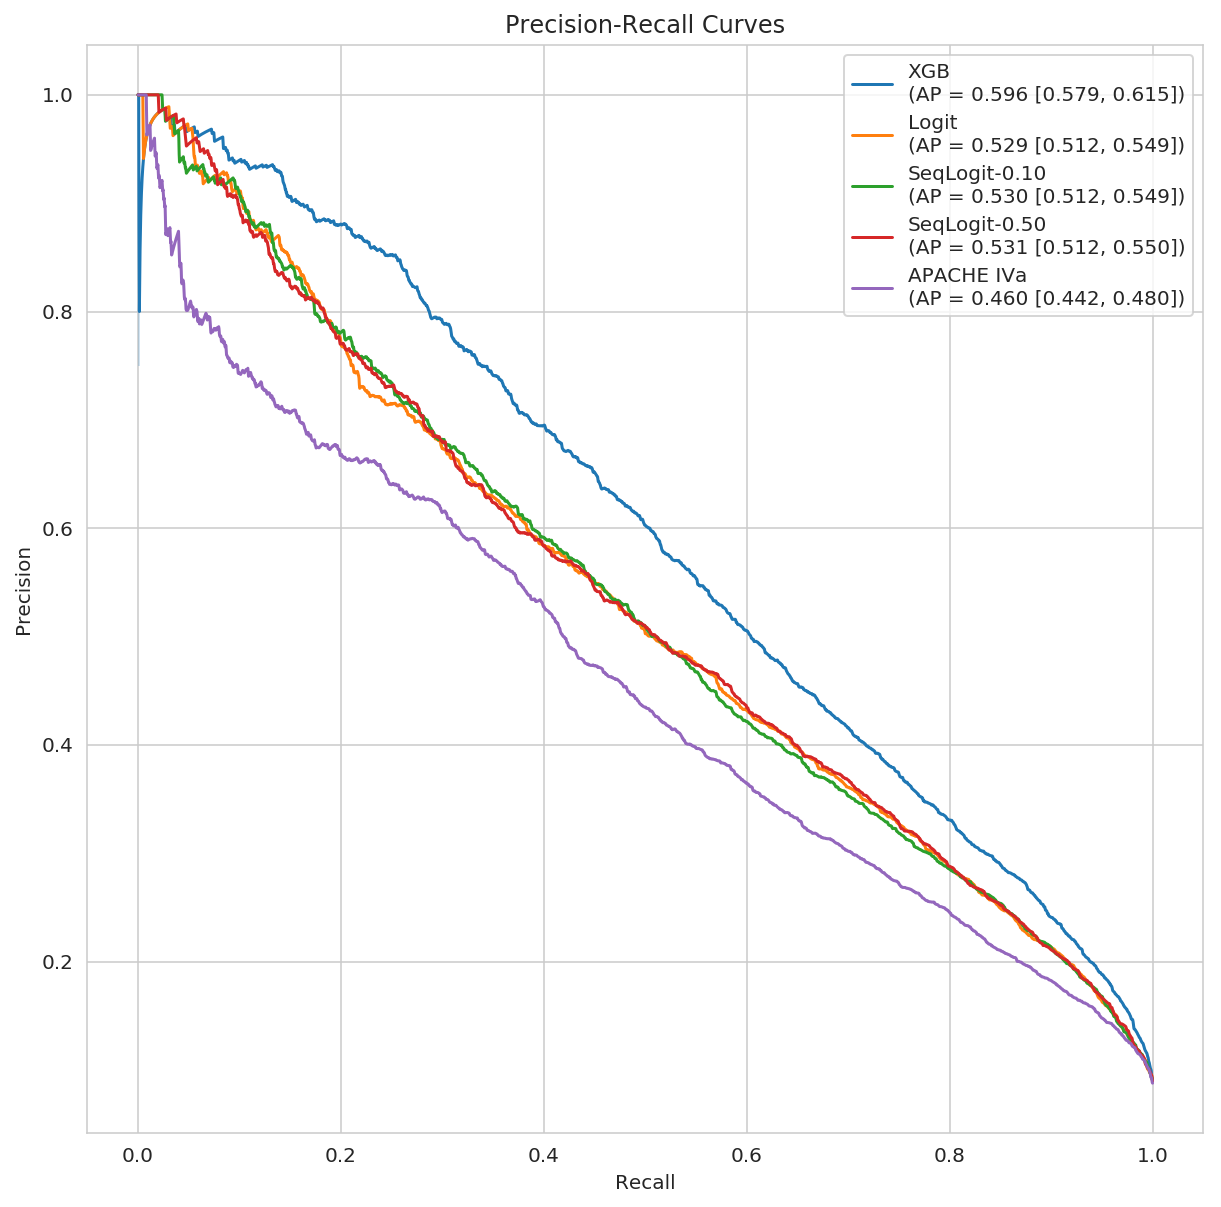

In [4]:
gen_prc_plot(models=[xgb_full, logit_full, seq_logit_HR, seq_logit_hHR, apache_model],
             names=['XGB', 'Logit', 'SeqLogit-0.10','SeqLogit-0.50', 'APACHE IVa'],
             title='Precision-Recall Curves', X=test_X, y=test_y, ci_level=0.95,
             save_name='auprc_all_models')

## 3 - Net Reclassification Index

In [5]:
additive_nri, absolute_nri = nri_grid(models=[apache_model, logit_full, seq_logit_HR, seq_logit_hHR, xgb_full],
                              names=['APACHE IVa', 'Logit', 'SeqLogit-0.10', 'SeqLogit-0.50', 'XGB'], 
                              X=test_X, y=test_y)
additive_nri

,APACHE IVa,Logit,SeqLogit-0.10,SeqLogit-0.50,XGB
APACHE IVa,0.0,42.0,38.0,36.0,64.0
Logit,-44.0,0.0,-9.0,-7.0,39.0
SeqLogit-0.10,-44.0,3.0,0.0,-3.0,44.0
SeqLogit-0.50,-39.0,7.0,9.0,0.0,44.0
XGB,-64.0,-36.0,-38.0,-42.0,0.0


In [6]:
absolute_nri

,APACHE IVa,Logit,SeqLogit-0.10,SeqLogit-0.50,XGB
APACHE IVa,0.0,48.0,47.0,47.0,62.0
Logit,-28.0,0.0,-2.0,-1.0,28.0
SeqLogit-0.10,-28.0,-3.0,0.0,3.0,28.0
SeqLogit-0.50,-28.0,1.0,2.0,0.0,28.0
XGB,-62.0,-47.0,-47.0,-48.0,0.0


## 4 - Calibration

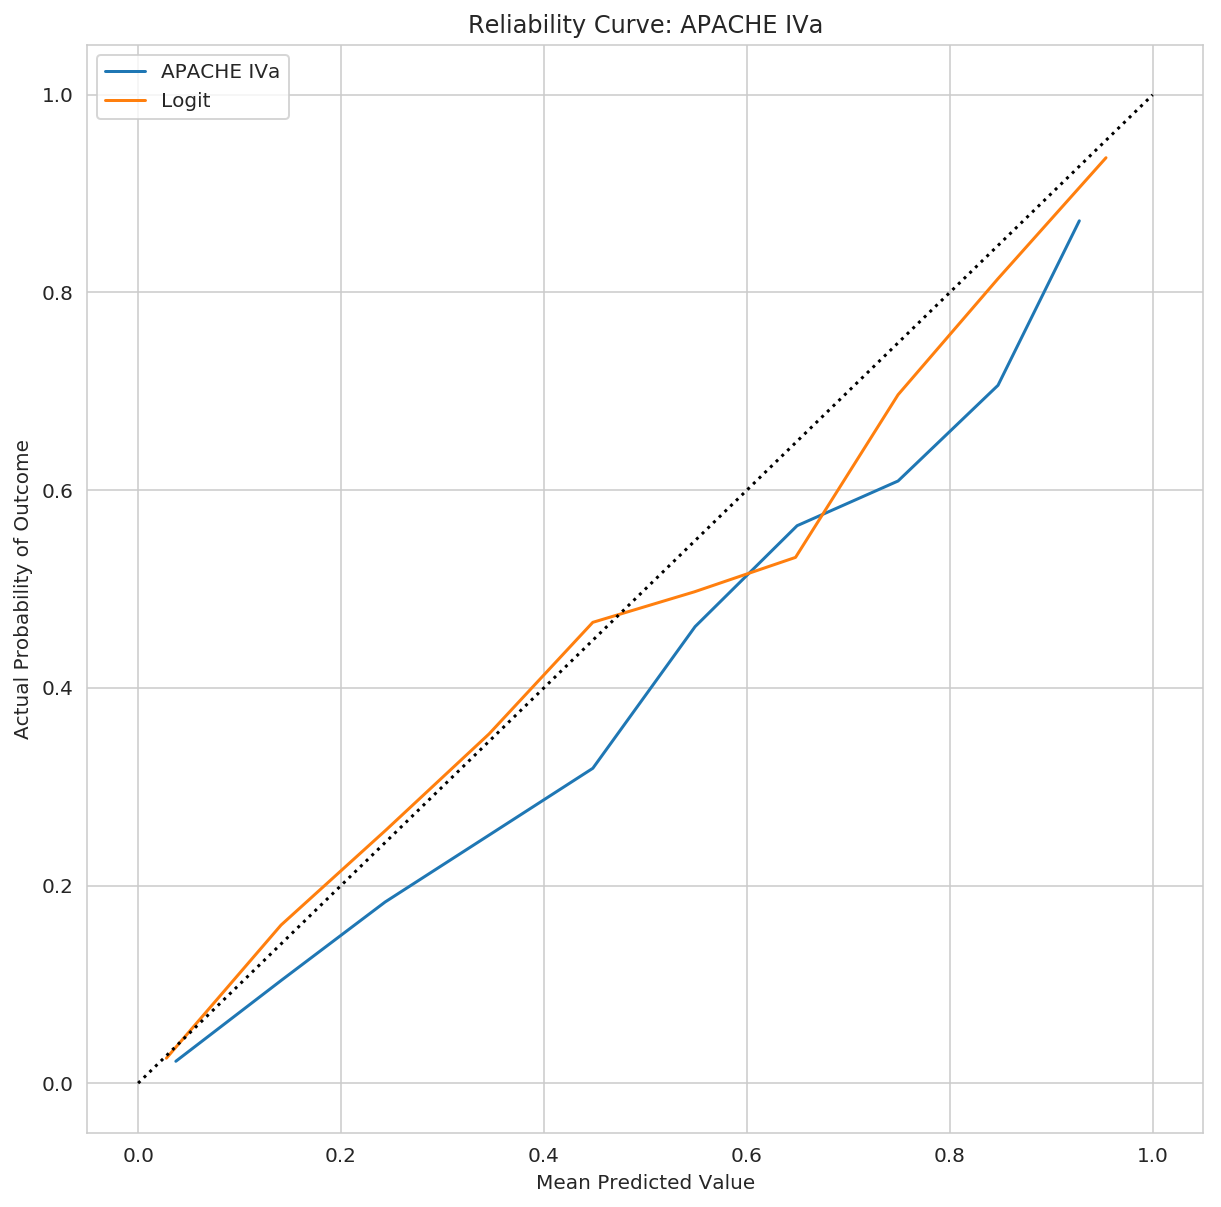

In [7]:
gen_calib_plot(models=[apache_model, logit_full], names=['APACHE IVa', 'Logit'], 
               title='Reliability Curve: APACHE IVa', X=test_X, y=test_y)

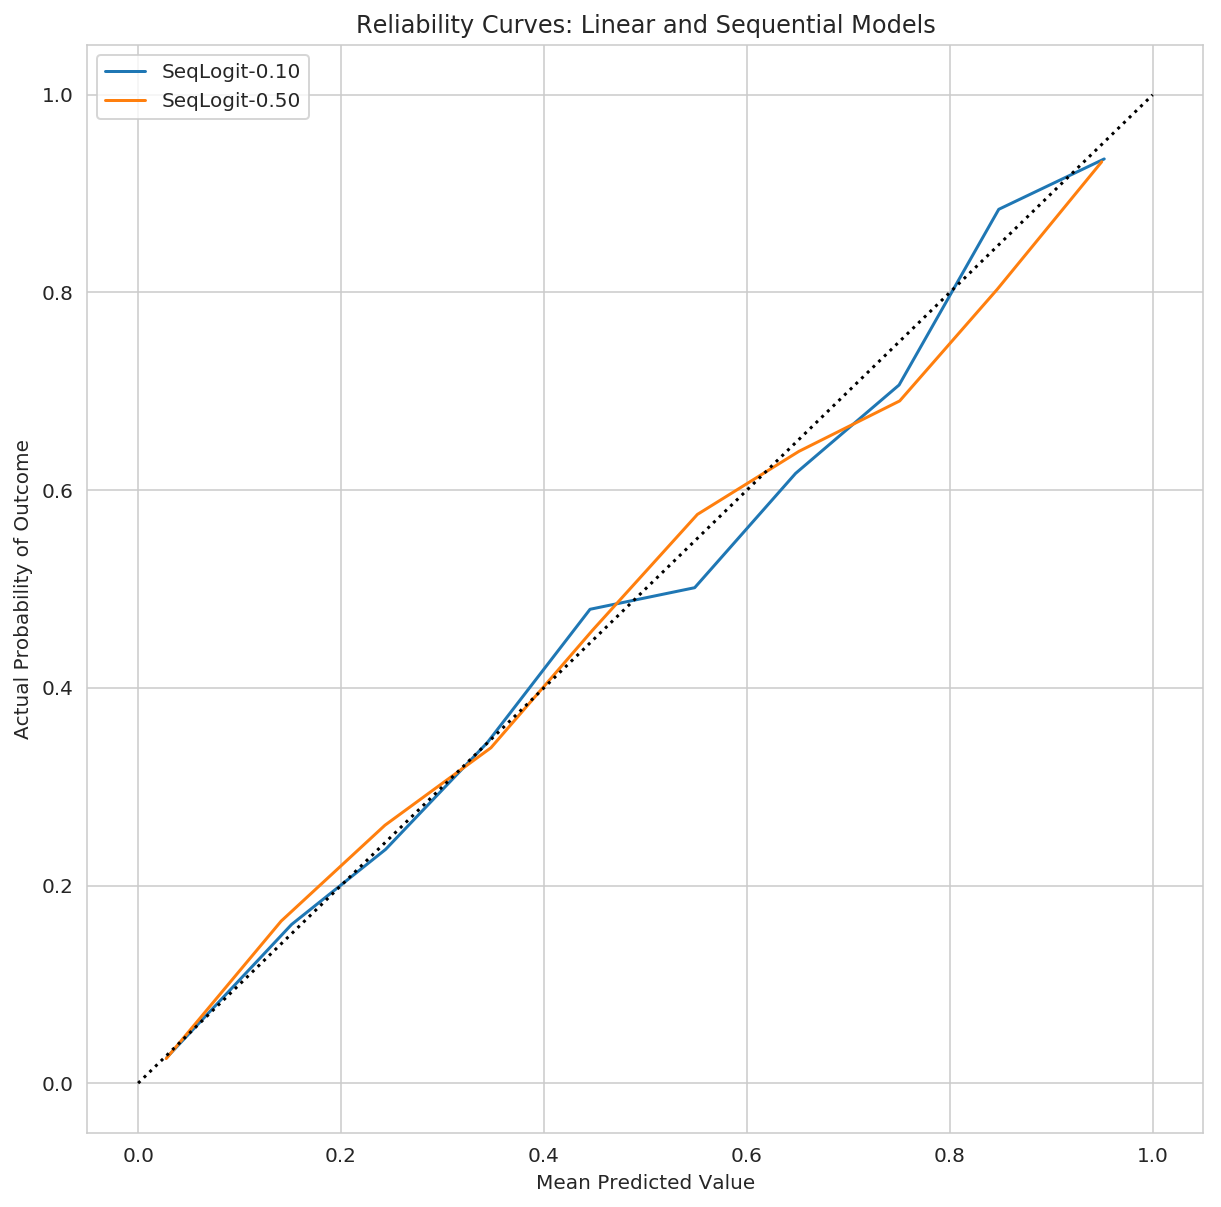

In [8]:
gen_calib_plot(models=[seq_logit_HR, seq_logit_hHR], names=['SeqLogit-0.10', 'SeqLogit-0.50'], 
             title='Reliability Curves: Linear and Sequential Models', X=test_X, y=test_y)

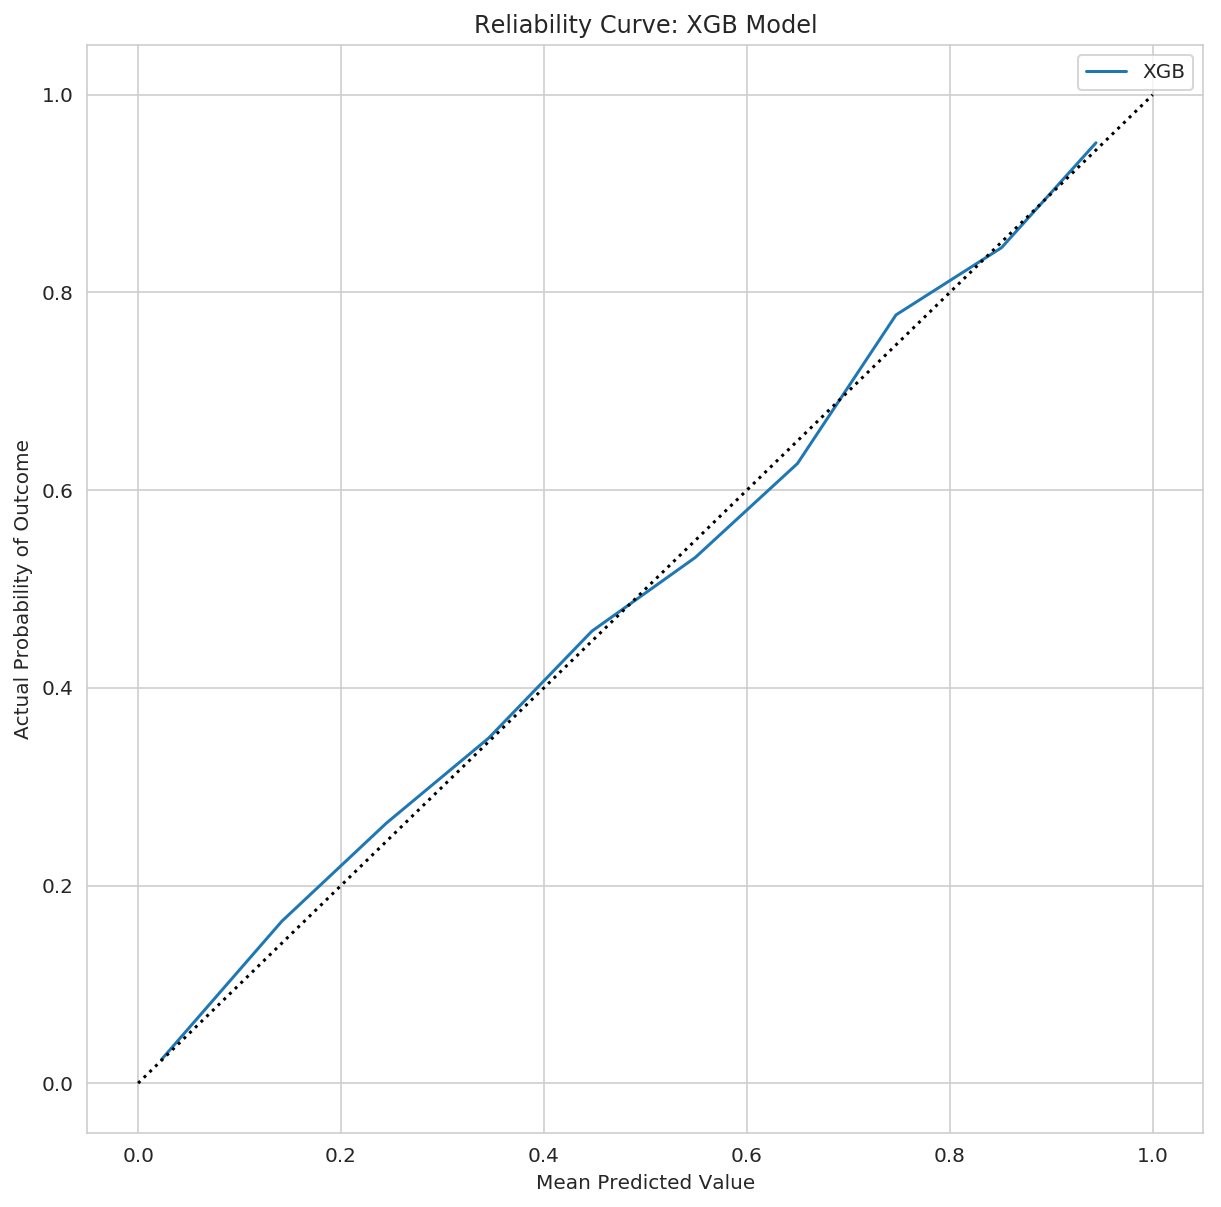

In [9]:
gen_calib_plot(models=[xgb_full], names=['XGB'], title='Reliability Curve: XGB Model', X=test_X, y=test_y)

## 5 - Observed-to-Predicted Mortality Ratios 

In [10]:
opr = opr_table(models=[apache_model, logit_full, seq_logit_HR, seq_logit_hHR, xgb_full],
                names=['APACHE IVa', 'Logit', 'SeqLogit-0.10', 'SeqLogit-0.50', 'XGB'],
                X=test_X, y=test_y)
opr

,OPR,2.5%,97.5%
APACHE IVa,0.738456,0.716430,0.759786
Logit,0.987696,0.958832,1.016887
SeqLogit-0.10,0.978241,0.950607,1.006162
SeqLogit-0.50,1.003416,0.974616,1.033317
XGB,1.039300,1.010097,1.068429
